## Component 3 

### Module Installation

### Implementation

In [76]:
# Import the libraries
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.applications import InceptionV3
from keras import backend as Bk

from sklearn.metrics import classification_report, confusion_matrix

In [3]:
train_dataset = pd.read_csv('./Emergency_Vehicles/train.csv')
test_dataset = pd.read_csv('./Emergency_Vehicles/test.csv')
train_dataset.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


In [4]:
train_dataset.shape[0]

1646

In [5]:
train_dataset['emergency_or_not'] = train_dataset['emergency_or_not'].astype(str)
train_dataset.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


In [6]:
train_dir = r'./Emergency_Vehicles/train'
test_dir = r'./Emergency_Vehicles/test'

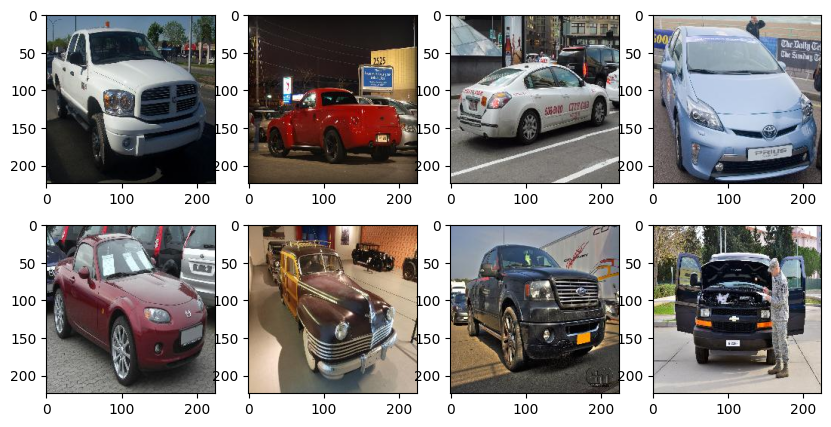

In [12]:
sample_class = os.listdir(train_dir)

fig = plt.figure(figsize=(10,5))
random.shuffle(sample_class)  # Shuffle the list of images randomly

for i in range(min(len(sample_class), 8)):  # Display the first 8 randomly shuffled images
    plt.subplot(2, 4, i+1)
    img = plt.imread(os.path.join(train_dir, sample_class[i]))
    plt.imshow(img, cmap=plt.get_cmap('gray'))

plt.show()

In [13]:
sample_img = cv2.imread(r'./Emergency_Vehicles/train/1.jpg')
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB) # converting to RGB

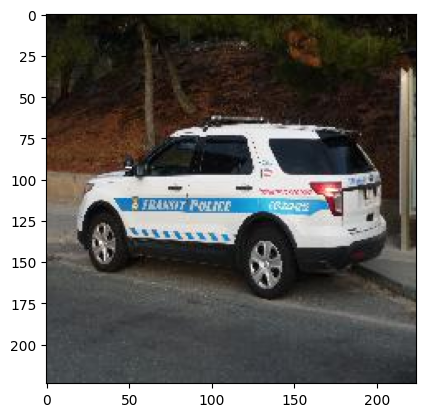

In [14]:
plt.imshow(sample_img)

In [15]:
#Define the image width and height to feed to a data generator 
sample_width = sample_img.shape[0]
sample_height = sample_img.shape[1]

# Initialize the batch size and the number of epoch/episodes.
batch_size = 40
epoch = 10

### Preprocessing 

In [16]:
# Applying our data transformations using ImageDataGenerators
trainimg_gen = ImageDataGenerator(
                            rotation_range= 20,
                            width_shift_range=0.1, 
                            height_shift_range=0.1,
                            shear_range=0.2, 
                            zoom_range=0.2,
                            fill_mode='nearest', 
                            horizontal_flip=True,
                            rescale= 1/255,
                            validation_split= 0.20
                            )

testimg_gen = ImageDataGenerator(rescale= 1/255)

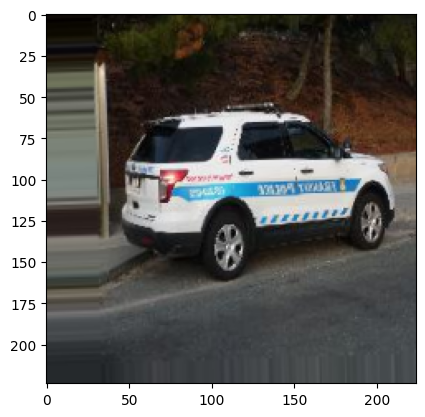

In [17]:
# showing the transformation
plt.imshow(trainimg_gen.random_transform(sample_img))

In [49]:

train_generator = trainimg_gen.flow_from_dataframe(
                                            dataframe= train_dataset,
                                            directory= train_dir,
                                            x_col= "image_names",
                                            y_col= "emergency_or_not",
                                            target_size= (sample_width, sample_height),
                                            batch_size= batch_size,
                                            class_mode= "binary",
                                            subset= 'training',
                                            shuffle= True,
                                            seed= 42
                                            )


valid_generator = trainimg_gen.flow_from_dataframe(
                                            dataframe= train_dataset,
                                            directory= train_dir,
                                            x_col= "image_names",
                                            y_col= "emergency_or_not",
                                            target_size= (sample_width, sample_height),
                                            batch_size= batch_size,
                                            class_mode= "binary",
                                            subset= 'validation',
                                            shuffle= True,
                                            seed= 42
                                            )


test_generator = testimg_gen.flow_from_dataframe(
                                            dataframe= test_dataset,
                                            directory= test_dir,
                                            x_col= "image_names",
                                            target_size= (224, 224),
                                            batch_size= 1,
                                            class_mode= None,
                                            shuffle= False,
                                            )

Found 863 validated image filenames belonging to 2 classes.
Found 215 validated image filenames belonging to 2 classes.
Found 706 validated image filenames.


/Users/samsiri/Documents/Understanding AI/submission_folder/.venv/lib/python3.11/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 568 invalid image filename(s) in x_col="image_names". These filename(s) will be ignored.
  warnings.warn(
/Users/samsiri/Documents/Understanding AI/submission_folder/.venv/lib/python3.11/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 568 invalid image filename(s) in x_col="image_names". These filename(s) will be ignored.
  warnings.warn(


### Model Architecture and Compilation.

#### Pretrained model Network Architecture (Base Model)

In [22]:
def model_architecture_with_inception():
    # Load the pre-trained InceptionV3 model, excluding the top (classification) layers
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(sample_width, sample_height, 3))
    
    # Freeze the pre-trained layers so they are not trained during the fine-tuning process
    for layer in base_model.layers:
        layer.trainable = False
    
    x = base_model.output
    x = Flatten()(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.2)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile the model
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
    
    return model

In [23]:
model_2 = model_architecture_with_inception()
model_2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 111, 111, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 111, 111, 32)         0         ['batch_normalization_94[0

#### Training pre-trained model

In [24]:
model2_history = model_2.fit_generator(train_generator,
                            validation_data = valid_generator,
                            steps_per_epoch = train_generator.n//train_generator.batch_size,
                            validation_steps = valid_generator.n//valid_generator.batch_size,
                            epochs=epoch)

/var/folders/52/mg3pw35120l4cfkybw3vlglw0000gn/T/ipykernel_82123/2630149007.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model2_history = model_2.fit_generator(train_generator,


Epoch 1/10
21/21 [==============================] - 20s 883ms/step - loss: 1.8139 - accuracy: 0.8493 - val_loss: 0.1347 - val_accuracy: 0.9200
Epoch 2/10
21/21 [==============================] - 18s 844ms/step - loss: 0.3035 - accuracy: 0.8870 - val_loss: 0.1825 - val_accuracy: 0.9200
Epoch 3/10
21/21 [==============================] - 18s 857ms/step - loss: 0.2902 - accuracy: 0.8809 - val_loss: 0.1351 - val_accuracy: 0.9250
Epoch 4/10
21/21 [==============================] - 18s 868ms/step - loss: 0.2738 - accuracy: 0.8858 - val_loss: 0.1061 - val_accuracy: 0.9150
Epoch 5/10
21/21 [==============================] - 18s 844ms/step - loss: 0.2409 - accuracy: 0.9101 - val_loss: 0.0713 - val_accuracy: 0.9350
Epoch 6/10
21/21 [==============================] - 18s 845ms/step - loss: 0.2274 - accuracy: 0.9235 - val_loss: 0.1277 - val_accuracy: 0.9550
Epoch 7/10
21/21 [==============================] - 18s 849ms/step - loss: 0.2443 - accuracy: 0.9271 - val_loss: 0.1011 - val_accuracy: 0.9350

#### Loss Graph of Pretrained model

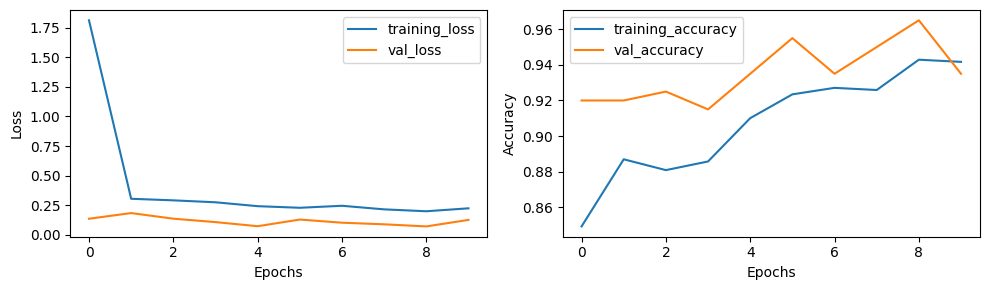

In [34]:
model2_historydf = pd.DataFrame(model2_history.history)
plt.figure(dpi=100, figsize=(10, 3))  
# Plot for Loss and Validation Loss
plt.subplot(1, 2, 1)  # Create the first subplot
plt.plot(model2_historydf['loss'], label='training_loss')
plt.plot(model2_historydf['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for Accuracy and Validation Accuracy
plt.subplot(1, 2, 2)  # Create the second subplot
plt.plot(model2_historydf['accuracy'], label='training_accuracy')
plt.plot(model2_historydf['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()  # Adjust spacing between subplots for better visualization
plt.show()

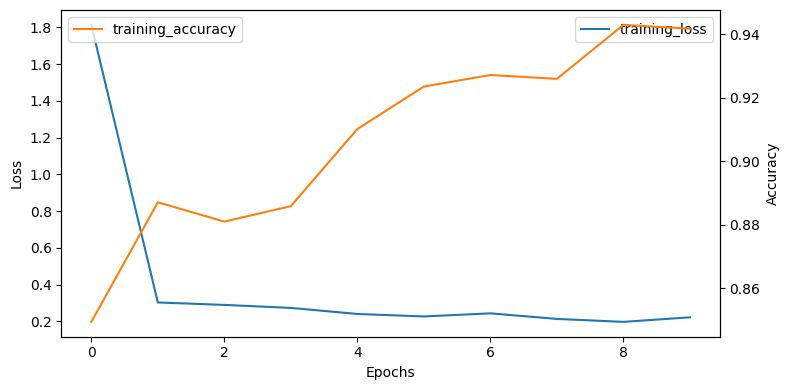

In [38]:
plt.figure(dpi=100, figsize=(8, 4))

# Plot for Loss and Validation Loss
plt.plot(model2_historydf['loss'], label='training_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for Accuracy and Validation Accuracy (using a secondary y-axis)
plt.gca().twinx()  # Create a secondary y-axis for the accuracy plot
plt.plot(model2_historydf['accuracy'], label='training_accuracy', color='tab:orange')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


#### Evaluation of pretrained network 

In [96]:
# Check the pretrained nekwork accuracy.
pt_score = model_2.evaluate(valid_generator)
print('Test loss:', pt_score[0])
print('Test accuracy:', pt_score[1])

6/6 [==============================] - 5s 643ms/step - loss: 0.1603 - accuracy: 0.9302
Test loss: 0.1603277176618576
Test accuracy: 0.930232584476471


In [111]:
# Get the true labels for the validation data
y_true = valid_generator.classes

# Predict the labels for the validation data using the model
y_pred_prob = model_2.predict_generator(valid_generator)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary class labels

# Generate the classification report
class_names = list(valid_generator.class_indices.keys())
report_str = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

df = pd.DataFrame(report_str).transpose()

# Print the DataFrame
display(df)


/var/folders/52/mg3pw35120l4cfkybw3vlglw0000gn/T/ipykernel_82123/319956042.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_prob = model_2.predict_generator(valid_generator)


,precision,recall,f1-score,support
0,0.910377,0.984694,0.946078,196.000000
1,0.000000,0.000000,0.000000,19.000000
accuracy,0.897674,0.897674,0.897674,0.897674
macro avg,0.455189,0.492347,0.473039,215.000000
weighted avg,0.829925,0.897674,0.862472,215.000000


In [81]:
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Convert the confusion matrix to a DataFrame for visualization
class_names = list(valid_generator.class_indices.keys())
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

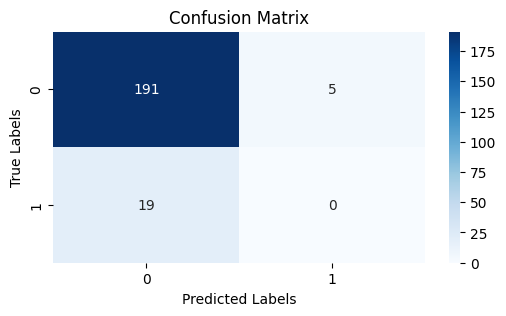

In [84]:
plt.figure(figsize=(6, 3))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

#### Prediction using the Pretrained network

In [58]:
imagenames = test_dataset['image_names'].to_list()

image_names = [name for name in imagenames if os.path.exists(os.path.join(test_dir, name))]

In [59]:
testimages = []
for name in image_names:
    # load the image
    img = cv2.imread(os.path.join(test_dir, name))

    # resize the image to the correct dimensions
    img = cv2.resize(img, (224, 224))
    
    # convert the image to floating point values in the range [0, 1]
    img = img.astype(np.float32) / 255.0

    # add the preprocessed image to the list
    testimages.append(img)
    
testimages = np.array(testimages)

In [86]:
# predict 
pt_predict=model_2.predict(test_generator, steps = len(test_generator.filenames))
pt_predict[:10] # show the probability of each class

706/706 [==============================] - 22s 31ms/step


array([[5.2014060e-02],
       [4.3900576e-01],
       [5.0060731e-05],
       [9.7737259e-01],
       [1.7294292e-06],
       [4.7195792e-01],
       [2.4315724e-02],
       [5.8828390e-01],
       [4.8516770e-03],
       [5.5933716e-03]], dtype=float32)

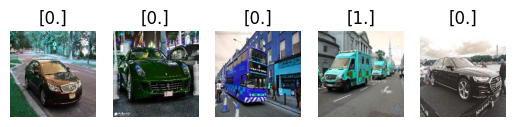

In [92]:
# round the predicted labels
pt_predict = np.round(pt_predict)

# Set the number of images to display
num_images_to_display = 5

# Get the indices of random images from the test batch
random_indices = random.sample(range(len(testimages)), num_images_to_display)

# Get the predicted class labels for the randomly selected images
pt_labels = pt_predict[random_indices]

# Get the corresponding images for the randomly selected images
img = testimages[random_indices]

# Create a figure with a grid of subplots
fig, axes = plt.subplots(1, num_images_to_display)

# Loop through the subplots and plot the images
for i in range(num_images_to_display):
    # Plot the image
    axes[i].imshow(img[i])
    axes[i].set_title(pt_labels[i])
    axes[i].axis('off')

# Show the figure
plt.show()

##### Summary

From the predictions, this shows the model performed very well and predicted the test sample accurately

#### model Architecture.

In [89]:
def define_model_architecture():
    # Initialize the model as a sequencial model
    model = Sequential()
    
    # Include a 2 Dimensional Convolutional layer with filters = 32, relu activation function and a kernel = (3,3)
    model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(sample_width, sample_height, 3)))
    
    # Include a max pooling layer with pool size = (2,2)
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Include a second 2D Convolutional layer with filters = 64, relu activation function and a kernel = (3,3)
    model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
    
    # Include a second max pooling layer with pool size = (2,2)
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
     # Include a dropout layer at rate of 0.5
    model.add(Dropout(0.5))
    
    model.add(Conv2D(64,kernel_size=(3,3),activation='relu',input_shape=(sample_width, sample_height, 3)))

    model.add(Conv2D(128,kernel_size=(3,3),activation='relu',input_shape=(sample_width, sample_height, 3)))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the model
    model.add(Flatten())
    
    # Include a Dense layer with 64 unit and relu activation function
    model.add(Dense(64, activation='relu'))
    
    # Include a dropout layer at rate of 0.2
    model.add(Dropout(0.2))
    
    # Include an outer dense layer of 1 unit and a sigmoid activation function.
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model.
    model.compile(loss="binary_crossentropy",optimizer="adam",metrics=['accuracy'])
    
    return model

In [90]:
dmodel = define_model_architecture()
dmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_188 (Conv2D)         (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_189 (Conv2D)         (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 54, 54, 64)        0         
                                                                 
 conv2d_190 (Conv2D)         (None, 52, 52, 64)        3

#### Training deep Model

In [93]:
model_history = dmodel.fit(train_generator,
                    validation_data = valid_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_steps = valid_generator.n//valid_generator.batch_size,
                    epochs=epoch)

Epoch 1/10
21/21 [==============================] - 16s 729ms/step - loss: 0.5542 - accuracy: 0.8688 - val_loss: 0.3526 - val_accuracy: 0.9050
Epoch 2/10
21/21 [==============================] - 19s 901ms/step - loss: 0.3710 - accuracy: 0.8797 - val_loss: 0.3625 - val_accuracy: 0.9100
Epoch 3/10
21/21 [==============================] - 15s 696ms/step - loss: 0.3587 - accuracy: 0.8821 - val_loss: 0.2987 - val_accuracy: 0.9150
Epoch 4/10
21/21 [==============================] - 15s 741ms/step - loss: 0.3360 - accuracy: 0.8834 - val_loss: 0.3499 - val_accuracy: 0.9100
Epoch 5/10
21/21 [==============================] - 17s 817ms/step - loss: 0.3300 - accuracy: 0.8821 - val_loss: 0.2612 - val_accuracy: 0.9200
Epoch 6/10
21/21 [==============================] - 19s 896ms/step - loss: 0.3021 - accuracy: 0.8870 - val_loss: 0.2850 - val_accuracy: 0.9150
Epoch 7/10
21/21 [==============================] - 17s 788ms/step - loss: 0.2913 - accuracy: 0.8894 - val_loss: 0.2521 - val_accuracy: 0.9250

#### Loss graph of  model

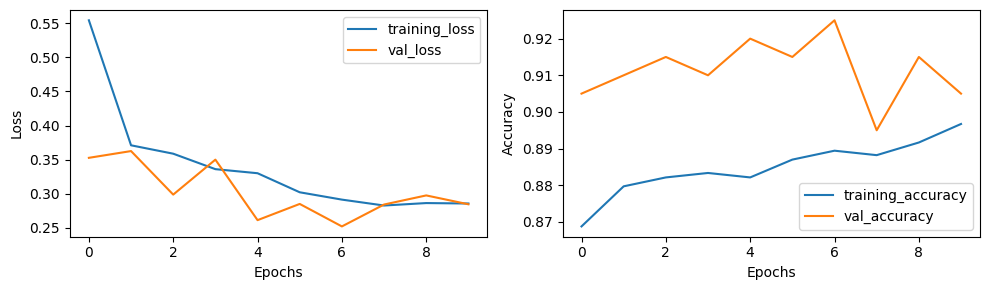

In [94]:
model_historydf = pd.DataFrame(model_history.history)
plt.figure(dpi=100, figsize=(10, 3))  
# Plot for Loss and Validation Loss
plt.subplot(1, 2, 1)  # Create the first subplot
plt.plot(model_historydf['loss'], label='training_loss')
plt.plot(model_historydf['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for Accuracy and Validation Accuracy
plt.subplot(1, 2, 2)  # Create the second subplot
plt.plot(model_historydf['accuracy'], label='training_accuracy')
plt.plot(model_historydf['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()  
plt.show()

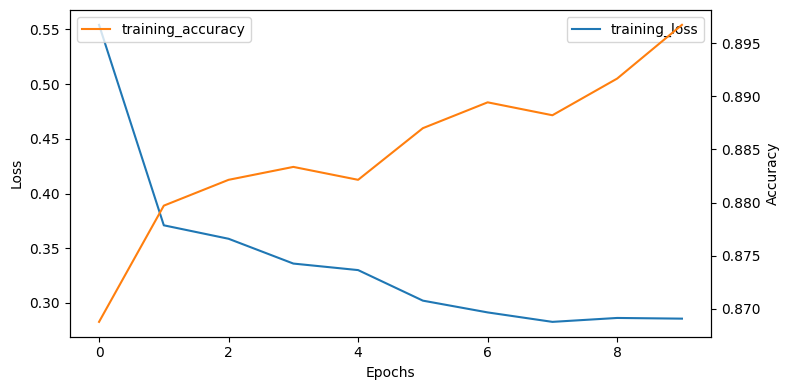

In [95]:
plt.figure(dpi=100, figsize=(8, 4))

# Plot for Loss and Validation Loss
plt.plot(model_historydf['loss'], label='training_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for Accuracy and Validation Accuracy (using a secondary y-axis)
plt.gca().twinx()  # Create a secondary y-axis for the accuracy plot
plt.plot(model_historydf['accuracy'], label='training_accuracy', color='tab:orange')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

#### Evaluation of model

In [97]:
# Check the main network accuracy.
deep_score = dmodel.evaluate(valid_generator)
print('Test loss:', deep_score[0])
print('Test accuracy:', deep_score[1])

6/6 [==============================] - 2s 206ms/step - loss: 0.3089 - accuracy: 0.9023
Test loss: 0.30887702107429504
Test accuracy: 0.9023255705833435


#### Prediction of model

In [106]:
deep_predict=dmodel.predict(test_generator, steps = len(test_generator.filenames))
deep_predict[:6] # show the probability of each class

706/706 [==============================] - 4s 6ms/step


array([[1.1619149e-05],
       [1.0467531e-01],
       [2.1876078e-05],
       [2.7195624e-01],
       [3.1781167e-10],
       [8.3155472e-05]], dtype=float32)

In [113]:
# Get the true labels (ground truth) for the validation data
y_dtrue = valid_generator.classes

# Predict the labels for the validation data using the model
y_dpred_prob = model_2.predict_generator(valid_generator)
y_dpred = (y_dpred_prob > 0.5).astype(int)  # Convert probabilities to binary class labels

# Generate the classification report
dreport_str = classification_report(y_dtrue, y_dpred, target_names=class_names, output_dict=True)

df2 = pd.DataFrame(dreport_str).transpose()

# Print the DataFrame
display(df2)

/var/folders/52/mg3pw35120l4cfkybw3vlglw0000gn/T/ipykernel_82123/809732254.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_dpred_prob = model_2.predict_generator(valid_generator)


,precision,recall,f1-score,support
0,0.909953,0.979592,0.943489,196.000000
1,0.000000,0.000000,0.000000,19.000000
accuracy,0.893023,0.893023,0.893023,0.893023
macro avg,0.454976,0.489796,0.471744,215.000000
weighted avg,0.829538,0.893023,0.860111,215.000000


In [114]:
# Generate the confusion matrix
cm2 = confusion_matrix(y_dtrue, y_dpred)

# Convert the confusion matrix to a DataFrame for visualization
cm_df2 = pd.DataFrame(cm, index=class_names, columns=class_names)


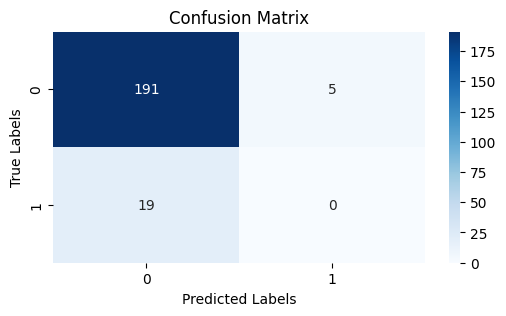

In [104]:
plt.figure(figsize=(6, 3))
sns.heatmap(cm_df2, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

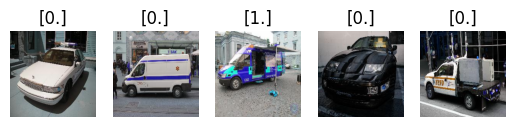

In [110]:
deep_predict = np.round(deep_predict)

#Set the number of images per batch
testbatch_size = 5

# Get the indices of random images from the test batch
random_index = random.sample(range(len(testimages)), testbatch_size)

# Get the predicted class labels for the current batch
dpredict_labels = deep_predict[random_index]

# Get the corresponding images for the current batch
img = testimages[random_index]

# Create a figure with a grid of subplots
fig, axes = plt.subplots(1, testbatch_size)

# Loop through the subplots and plot the images

for i in range(testbatch_size):
    # Plot the image
    axes[i].imshow(img[i])
    axes[i].set_title(dpredict_labels[i])
    axes[i].axis('off')

# Show the figure
plt.show()

##### Summary

Prediction in the model is also accurate but based on the 